In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import os, sys
import ipynbname
nb_name = ipynbname.name()
import time
from glob import glob
import itertools
import pprint
pp = pprint.PrettyPrinter()

import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import h5py

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Timing utilities
start_time = None

def start_timer():
    global start_time
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print():
    torch.cuda.synchronize()
    end_time = time.time()
    print("\nTotal execution time {:.3f} sec".format(end_time - start_time))

## Loading Data

In [4]:
CA3_size = 2048
EC_size = 1024

In [5]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        #return torch.sign(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)

class StraightThroughEstimator(nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        return STEFunction.apply(x)

In [6]:
def conv_output_size(size, kernel_size=1, stride=1, padding=0, dilation=1):
    return (size + (2 * padding) - (dilation * (kernel_size - 1)) - 1) // stride + 1

class ConvolutionalAE(nn.Module):
    def __init__(self, num_filters=32, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_filters = num_filters
        self.conv_output_size = conv_output_size(28, kernel_size=kernel_size,
                                                 stride=stride, padding=padding)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel_size,
                      stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(num_filters * self.conv_output_size**2, EC_size),
            nn.BatchNorm1d(EC_size),
            StraightThroughEstimator()
        )
        self.decoder = nn.Sequential(
            nn.Linear(EC_size, num_filters * self.conv_output_size**2),
            nn.Unflatten(-1, (num_filters, self.conv_output_size, self.conv_output_size)),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            nn.ConvTranspose2d(num_filters, 1, kernel_size=kernel_size,
                               stride=stride, padding=padding),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features)
        return x, features

In [7]:
AE_model = ConvolutionalAE(num_filters=16, kernel_size=12, stride=6, padding=4).to(device)
AE_data = torch.load(f"data/{nb_name}_model.pt", map_location='cpu')
AE_model.load_state_dict(AE_data['model_state_dict'])

<All keys matched successfully>

In [8]:
true_imgs = torch.cat(AE_data['X_by_class'])
AE_imgs = torch.cat(AE_data['pred_by_class'])
AE_features = torch.cat(AE_data['features_by_class'])
print(AE_features.shape, AE_features.dtype)

torch.Size([768, 1024]) torch.float32


In [9]:
true_categories = torch.stack(AE_data['X_concepts'])
AE_categories = torch.stack(AE_data['pred_concepts'])
AE_assimilations = torch.stack(AE_data['features_concepts'])
print(AE_assimilations.shape, AE_assimilations.dtype)

torch.Size([3, 1, 28, 28]) torch.float32


In [10]:
def read_binary_patterns(pattern_file, pattern_size=CA3_size):
    binfile = open(pattern_file, 'rb')
    bindata = np.fromfile(binfile, dtype=np.uint8)
    binfile.close()
    patterns = torch.as_tensor(np.unpackbits(bindata).reshape((-1, pattern_size)), dtype=torch.float)
    print(patterns.shape, patterns.dtype)
    return patterns

sparse_patterns = read_binary_patterns(f"data/{nb_name}_hopfield/x_sparse.dat")
dense_patterns = read_binary_patterns(f"data/{nb_name}_hopfield/x_dense.dat")
category_patterns = read_binary_patterns(f"data/{nb_name}_hopfield/x_cat.dat")

torch.Size([768, 2048]) torch.float32
torch.Size([768, 2048]) torch.float32
torch.Size([3, 2048]) torch.float32


In [51]:
def plot_images(img_list, num=6, size=12):
    if isinstance(img_list, tuple):
        img_list = list(img_list)
    elif isinstance(img_list, (np.ndarray, torch.Tensor)):
        img_list = [img_list]
    else:
        raise Exception("input must be ndarray or sequence or list of ndarrays")
        
    for i in range(len(img_list)):
        if isinstance(img_list[i], torch.Tensor):
            img_list[i] = img_list[i].cpu().numpy()
            
        depth = img_list[i].ndim
        if depth == 4:
            continue
        elif depth == 3:
            img_list[i] = np.expand_dims(img_list[i], 0)
        elif depth == 2:
            img_list[i] = np.expand_dims(img_list[i], (0,1))
        else:
            raise Exception("image arrays must have depth between 2 and 4, inclusive")
            
    lengths = [imgs.shape[0] for imgs in img_list]
    if lengths.count(lengths[0]) != len(lengths):
        raise Exception("image arrays must have the same first dimension size")
    if num == -1 or num > lengths[0]:
        num = lengths[0]
    num_list = len(img_list)
    
    if num == 1:
        plt.figure(figsize=(size, size/num_list))
        for i, img in enumerate(img_list):
            plt.subplot(1, num_list, i+1)
            plt.imshow(img[0, 0], cmap='gray_r')
            plt.axis('off')
    else:
        plt.figure(figsize=(size, size*num_list/num))
        for i, imgs in enumerate(img_list):
            for j, img in enumerate(imgs):
                if j >= num: break
                plt.subplot(num_list, num, num*i+j+1)
                plt.imshow(img[0], cmap='gray_r')
                plt.axis('off')
    
    plt.show()

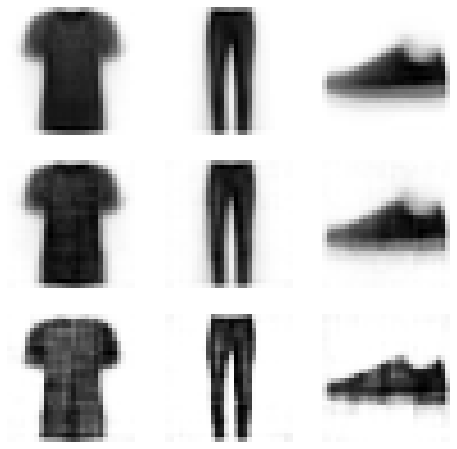

In [12]:
plot_images((true_categories, AE_categories, AE_assimilations), size=8)

## Creating Dataset and Dataloader

In [13]:
class FeedforwardDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        if len(X) != len(Y):
            raise Exception("input and output patterns must have same length")

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        X_sample = self.X[idx]
        Y_sample = self.Y[idx]
        
        if self.transform:
            X_sample = self.transform(X_sample)
            Y_sample = self.transform(Y_sample)
        
        return (X_sample, Y_sample)

In [15]:
sparse_data = FeedforwardDataset(sparse_patterns, AE_features)
dense_data = FeedforwardDataset(dense_patterns, AE_features)

batch_size = 64
FF_dataloaders = (DataLoader(sparse_data, batch_size=batch_size, shuffle=True),
               DataLoader(dense_data, batch_size=batch_size, shuffle=True))

print("Number of batches: ", len(FF_dataloaders[0]))

for X, Y in FF_dataloaders[0]:
    print("Shape of X: ", X.shape, X.dtype)
    print("Shape of Y: ", Y.shape, Y.dtype)
    break

Number of batches:  12
Shape of X:  torch.Size([64, 2048]) torch.float32
Shape of Y:  torch.Size([64, 1024]) torch.float32


## Training feedforward network from CA3 to autoencoder

In [17]:
class Feedforward(nn.Module):
    def __init__(self, hidden_size=2*CA3_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.feedforward = nn.Sequential(
            nn.Linear(CA3_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, EC_size),
            #nn.BatchNorm1d(EC_size),
            #StraightThroughEstimator()
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.feedforward(x)

def step(x):
    return (x > 0.5).float()

In [23]:
def train(dataloaders, model, err_criterion, optimizer, num_epochs):
    size = len(dataloaders[0].dataset)
    #num_batches = len(dataloaders[0])
    
    model.train()
    
    Y_list = [[], []]
    pred_list = [[], []]
    
    for t in range(num_epochs):
        mean_loss = np.array([0, 0], dtype=float)
        mean_overlap = np.array([0, 0], dtype=float)
        mean_sparsity = np.array([0, 0], dtype=float)
    
        for tt, dataloader in enumerate(dataloaders):
            for X, Y in dataloader:
                X, Y = X.to(device), Y.to(device)
                output = model(X)

                loss = err_criterion(Y, output)
                mean_loss[tt] += loss.item() * len(Y)
                pred = step(output.detach())
                with torch.no_grad():
                    overlaps = (Y * pred).sum(1) / Y.sum(1)
                    mean_overlap[tt] += overlaps.sum().item()
                    sparsities = pred.mean(1)
                    mean_sparsity[tt] += sparsities.sum().item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
        
            Y_list[tt].append(Y.detach())
            pred_list[tt].append(pred)

        mean_loss = (mean_loss / size)**0.5
        mean_overlap = mean_overlap / size
        mean_sparsity = mean_sparsity / size
        print(f"{t:>3d})   ", end='')
        print(f"RMSE: {mean_loss[0]:>5f} {mean_loss[1]:>5f},  ", end='')
        print(f"overlap: {mean_overlap[0]:>5f} {mean_overlap[1]:>5f},  ", end='')
        print(f"sparsity: {mean_sparsity[0]:>3f} {mean_sparsity[1]:>3f}")
    
    return Y_list, pred_list

In [24]:
FF_model = Feedforward(hidden_size=2*CA3_size).to(device)
print(FF_model)

FF_criterion = nn.MSELoss(reduction='mean')
FF_optimizer = torch.optim.Adam(FF_model.parameters(), lr=1e-4, weight_decay=1e-5)

Feedforward(
  (feedforward): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): Sigmoid()
  )
)


In [25]:
num_epochs = 80
start_timer()
train_Y, train_pred = train(FF_dataloaders, FF_model, FF_criterion, FF_optimizer, num_epochs)
end_timer_and_print()
print("Done!")

  0)   RMSE: 0.406717 0.337487,  overlap: 0.106844 0.001759,  sparsity: 0.105583 0.000266
  1)   RMSE: 0.333581 0.322499,  overlap: 0.002706 0.035270,  sparsity: 0.000417 0.005093
  2)   RMSE: 0.324863 0.302380,  overlap: 0.009870 0.114087,  sparsity: 0.001362 0.017445
  3)   RMSE: 0.314408 0.284050,  overlap: 0.024111 0.239924,  sparsity: 0.003323 0.037008
  4)   RMSE: 0.301971 0.267956,  overlap: 0.052585 0.356225,  sparsity: 0.007418 0.053589
  5)   RMSE: 0.288189 0.253749,  overlap: 0.112174 0.452429,  sparsity: 0.015902 0.066035
  6)   RMSE: 0.274046 0.241166,  overlap: 0.195689 0.527301,  sparsity: 0.027588 0.075526
  7)   RMSE: 0.260310 0.229386,  overlap: 0.293040 0.594575,  sparsity: 0.041064 0.083593
  8)   RMSE: 0.246765 0.218466,  overlap: 0.387967 0.649743,  sparsity: 0.053584 0.090192
  9)   RMSE: 0.234003 0.208482,  overlap: 0.479235 0.702096,  sparsity: 0.065645 0.096416
 10)   RMSE: 0.222449 0.199064,  overlap: 0.553860 0.742738,  sparsity: 0.075180 0.101097
 11)   RMS

In [26]:
AE_model.eval()
with torch.no_grad():
    train_sparse_imgs = [AE_model.decoder(Y) for Y in train_Y[0]]
    train_dense_imgs = [AE_model.decoder(Y) for Y in train_Y[1]]
    train_sparse_recons = [AE_model.decoder(pred) for pred in train_pred[0]]
    train_dense_recons = [AE_model.decoder(pred) for pred in train_pred[1]]

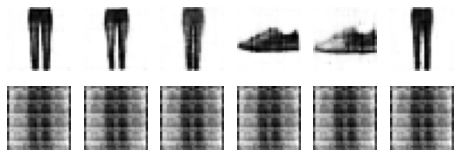

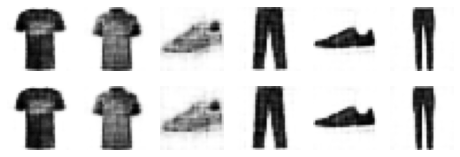

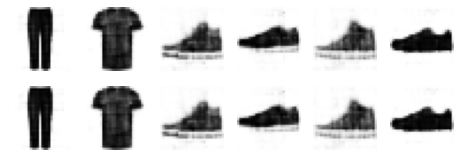

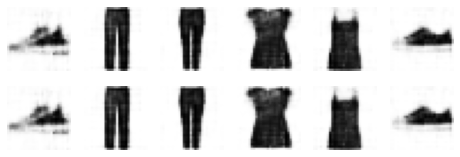

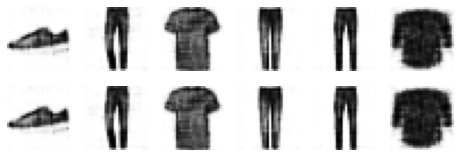

In [27]:
for t in list(range(0, num_epochs, 20)) + [num_epochs-1]:
    plot_images((train_sparse_imgs[t], train_sparse_recons[t]), size=8)

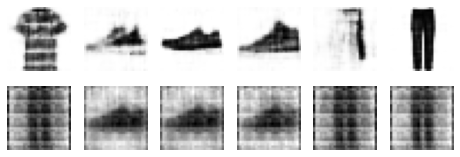

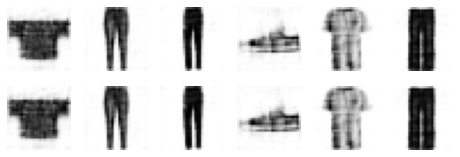

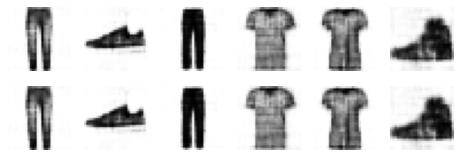

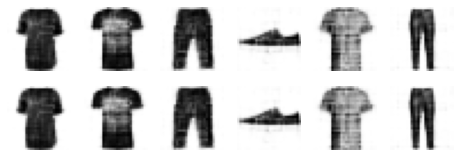

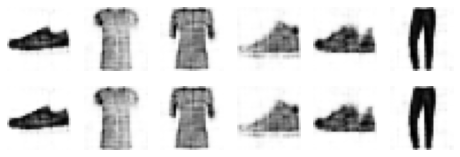

In [28]:
for t in list(range(0, num_epochs, 20)) + [num_epochs-1]:
    plot_images((train_dense_imgs[t], train_dense_recons[t]), size=8)

## Testing Feedforward network

In [32]:
def test(dataloaders, model):
    size = len(dataloaders[0].dataset)
    model.eval()
    
    Y_list = [[], []]
    pred_list = [[], []]
    
    mean_overlap = np.array([0, 0], dtype=float)
    mean_sparsity = np.array([0, 0], dtype=float)
    
    with torch.no_grad():
        for tt, dataloader in enumerate(dataloaders):
            for X, Y in dataloader:
                X, Y = X.to(device), Y.to(device)
                output = model(X)
                pred = step(output.detach())

                overlaps = (Y * pred).sum(1) / Y.sum(1)
                mean_overlap[tt] += overlaps.sum().item()
                sparsities = pred.mean(1)
                mean_sparsity[tt] += sparsities.sum().item()

        
            Y_list[tt].append(Y.detach())
            pred_list[tt].append(pred)   
            
    mean_overlap = mean_overlap / size
    mean_sparsity = mean_sparsity / size
    print(f"overlap: {mean_overlap[0]:>5f} {mean_overlap[1]:>5f},  ", end='')
    print(f"sparsity: {mean_sparsity[0]:>3f} {mean_sparsity[1]:>3f}")
    
    Y_list = [torch.cat(Y) for Y in Y_list]
    pred_list = [torch.cat(pred) for pred in pred_list]

    return Y_list, pred_list

In [33]:
test_Y, test_pred = test(FF_dataloaders, FF_model)

overlap: 0.995676 1.000000,  sparsity: 0.131120 0.131634


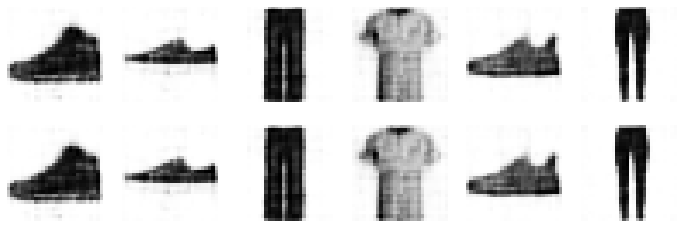

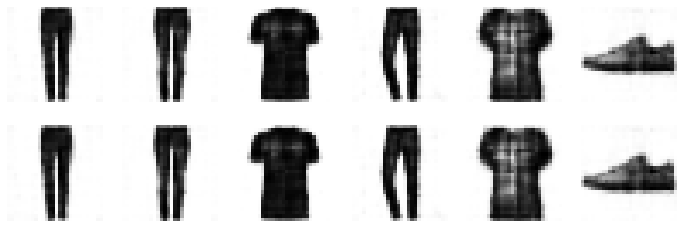

In [35]:
AE_model.eval()
with torch.no_grad():
    test_sparse_imgs = AE_model.decoder(test_Y[0])
    test_dense_imgs = AE_model.decoder(test_Y[1])
    test_sparse_recons = AE_model.decoder(test_pred[0])
    test_dense_recons = AE_model.decoder(test_pred[1])
    
plot_images((test_sparse_imgs, test_sparse_recons))
plot_images((test_dense_imgs, test_dense_recons))

## Visualizing CA3 dynamics

- dc-x1: Mean overlap 0.096 --> 0.353
- dc-x2: Mean overlap 0.095 --> 0.376
- dc-x3: Mean overlap 0.089 --> 0.394
- dc-x4: Mean overlap 0.105 --> 0.411
- dc-x5: Mean overlap 0.086 --> 0.416
- dc-x6: Mean overlap 0.112 --> 0.367
- dc-x7: Mean overlap 0.058 --> 0.345
- dc-x8: Mean overlap 0.080 --> 0.348
- ds-x1: Mean overlap 0.015 --> 0.939
- ds-x2: Mean overlap 0.050 --> 0.908
- ds-x3: Mean overlap 0.049 --> 0.827
- ds-x4: Mean overlap 0.031 --> 0.873
- ds-x5: Mean overlap 0.061 --> 0.644
- ds-x6: Mean overlap 0.041 --> 0.718
- ds-x7: Mean overlap 0.037 --> 0.749
- ds-x8: Mean overlap 0.025 --> 0.798
- sc-x1: Mean overlap 0.006 --> 0.292
- sc-x2: Mean overlap 0.005 --> 0.302
- sc-x3: Mean overlap 0.005 --> 0.326
- sc-x4: Mean overlap 0.006 --> 0.228
- sc-x5: Mean overlap 0.004 --> 0.352
- sc-x6: Mean overlap 0.006 --> 0.351
- sc-x7: Mean overlap 0.005 --> 0.376
- sc-x8: Mean overlap 0.006 --> 0.332
- ss-x1: Mean overlap 0.508 --> 1.001
- ss-x2: Mean overlap 0.498 --> 1.001
- ss-x3: Mean overlap 0.496 --> 0.953
- ss-x4: Mean overlap 0.500 --> 0.946
- ss-x5: Mean overlap 0.503 --> 1.001
- ss-x6: Mean overlap 0.505 --> 1.001
- ss-x7: Mean overlap 0.503 --> 1.001
- ss-x8: Mean overlap 0.515 --> 1.001

In [78]:
filebases = ["dc-x1", "ds-x1", "sc-x1", "ss-x1"]
fileroots = [f"data/{nb_name}_hopfield/{base}" for base in filebases]

In [79]:
num_categories = 3
num_examples = 100
max_examples = len(sparse_patterns) // len(category_patterns)

cue_inds = [np.genfromtxt(f"{root}_qcue.txt", dtype='int') for root in fileroots]
mu_inds = [np.genfromtxt(f"{root}_qmu.txt", dtype='int') for root in fileroots]
nu_inds = [np.genfromtxt(f"{root}_qnu.txt", dtype='int') for root in fileroots]

num_cues = len(cue_inds[0])
print(num_cues)

30


In [80]:
storage_inds = [np.hstack([mu*max_examples + nus for mu in mus])
                for mus, nus in zip(mu_inds, nu_inds)]
target_inds = [cue // num_examples if base[1] == 'c' else storage[cue]
               for cue, storage, base in zip(cue_inds, storage_inds, filebases)]

In [81]:
target_imgs = [true_categories[target] if base[1] == 'c' else true_imgs[target]
               for target, base in zip(target_inds, filebases)]

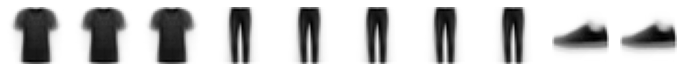

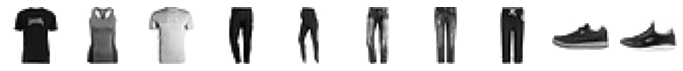

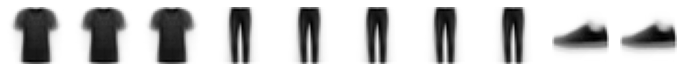

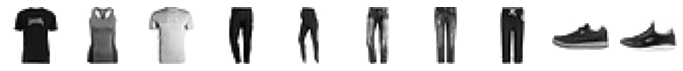

In [82]:
for imgs in target_imgs:
    plot_images(imgs[::3], num=-1)

In [83]:
raw_activities = [read_binary_patterns(f"{root}_s.dat") for root in fileroots]
hopfield_activities = [activity.view((num_cues, -1, activity.shape[-1]))
                       for activity in raw_activities]

torch.Size([4830, 2048]) torch.float32
torch.Size([4830, 2048]) torch.float32
torch.Size([4830, 2048]) torch.float32
torch.Size([4830, 2048]) torch.float32


In [84]:
hopfield_activities = [read_binary_patterns(f"{root}_s.dat") for root in fileroots]

torch.Size([4830, 2048]) torch.float32
torch.Size([4830, 2048]) torch.float32
torch.Size([4830, 2048]) torch.float32
torch.Size([4830, 2048]) torch.float32


In [85]:
FF_model.eval()
AE_model.eval()
with torch.no_grad():
    hopfield_imgs = [AE_model.decoder(step(FF_model(activities.to(device))))
                     for activities in hopfield_activities]
    hopfield_imgs = [imgs.view((num_cues, -1, *imgs.shape[-3:])) for imgs in hopfield_imgs]

dc-x1


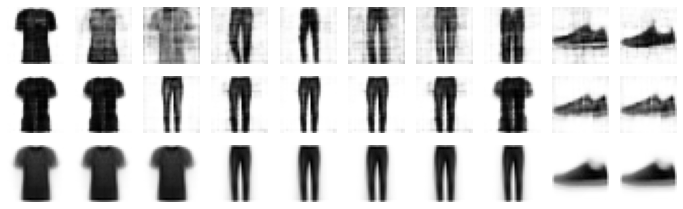




ds-x1


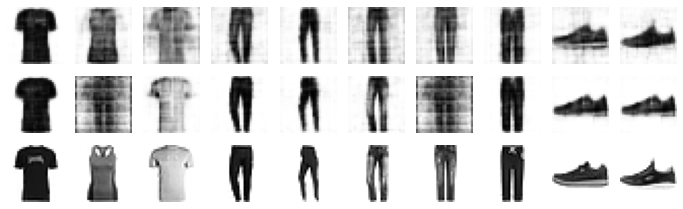




sc-x1


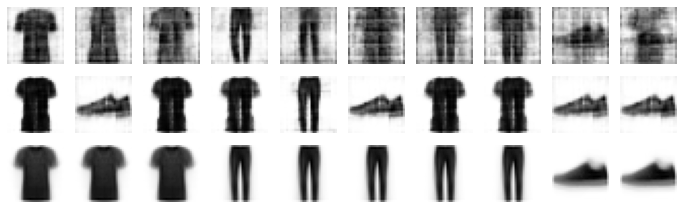




ss-x1


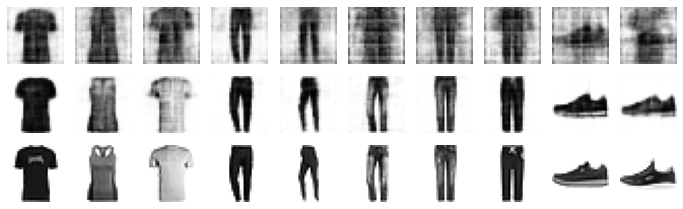

In [86]:
for hopfield, target, base in zip(hopfield_imgs, target_imgs, filebases):
    print(f"{base}")
    plot_images((hopfield[::3,0], hopfield[::3,-1], target[::3]), num=-1)
    torch.cuda.synchronize()
    print(f"\n\n")

In [87]:
for base, hopfield, target, cues in zip(filebases, hopfield_imgs, target_imgs, cue_inds):
    categories = cues // num_examples
    
    h5file = h5py.File(f'results/{nb_name}_{base}.h5', 'w')
    h5file.create_dataset("categories", data=categories)
    h5file.create_dataset("hopfield", data=hopfield.cpu().numpy(), compression='gzip')
    h5file.create_dataset("target", data=target.cpu().numpy(), compression='gzip')
    h5file.close()